# COGS 108 - EDA Checkpoint

# Names
- Aung Kyaw
- Ojeen Gammah
- Hyunmin Lim
- Tina Nguyen
- Anthony Yiu

<a id='research_question'></a>
# Research Question

What (if any) are the correlations between rising global temperatures and the rate of natural disasters (counted by the number of people affected and left homeless)?

What (if any) are the correlations between the rate of natural disasters (counted by the number of people affected and left homeless) and the number suicides between men and women?

Based on the two questions above, what (if any) are the correlations between rising global temperatures and the number of suicides between men and women?

Is this solely due to global temperatures or is global temperatures causing more people to be affected by natural disasters thus increasing the number of suicides? How does that differ between men and women?

# Hypothesis
We predit that rising global temperatures will result in higher suicide rates amongst men and women and this will be due to the external factor of rising global temperatures causing more people to be affected and left homeless by natural disasters.

# Setup

In [ ]:
## YOUR CODE HERE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import sklearn
from sklearn import linear_model
climate_url = "https://raw.githubusercontent.com/AnthonyQY/cogs108data/master/climate_change.csv"
homeless_url = "https://raw.githubusercontent.com/AnthonyQY/cogs108data/master/homeless-natural-disasters.csv"
disasters_url = "https://query.data.world/s/u37knx7md7thvlvtmz3mut4n6qv5xa"
suicide_url = "https://raw.githubusercontent.com/AnthonyQY/cogs108data/master/suicide-death-rates-by-sex.csv"

df_climate = pd.read_csv(climate_url)

df_homeless = pd.read_csv(homeless_url, sep=";")

df_disasters = pd.read_csv(disasters_url, sep=";")

df_suicide = pd.read_csv(suicide_url)

# Data Cleaning

Describe your data cleaning steps here.

 Cleaning the climate change dataset below by removing all of the series names that aren't named "Co2 emissions, total (KtCO2)". We then put the series names into a new data column "Statistic" to create a uniform column between all the dataset.

In [ ]:
#df_climate_distinct = df_climate.drop_duplicates(subset=["Country code"])
df_climate = df_climate.loc[df_climate['Series name'].isin (['CO2 emissions, total (KtCO2)'])].reset_index(drop=True)
df_climate = df_climate[["Country code","Series name", "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008"]]
df_climate.rename(columns = {"Series name": "Statistic"}, inplace=True)
df_climate.rename(columns = {"Country code": "Country Code"}, inplace=True)
df_climate

We cleaned the homeless dataset to get years that we are looking for across all the datasets. Then naming the dataset for what the data accounts for into Statistics. We also limited the years to the specific range that is avaliable in all other datasets for ease when combining.

In [ ]:
df_homeless = df_homeless[["Country Code", "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008"]]
df_homeless.fillna(0, inplace=True)
df_homeless_distinct = df_homeless.drop_duplicates(subset=["Country Code"])
df_homeless.insert(loc=1,
          column='Statistic',
          value="Number of Homeless")
homeless_distinct_countries = df_homeless_distinct.shape[0]
homeless_distinct_countries
df_homeless

The disaster dataset, we cleaned the dataset years columns to get years we are looking for across all datasets. Then we dropped any duplicates in the dataset. From there we named the Statistics column to what the data accounts for. We also limited the years to the specific range that is avaliable in all other datasets for ease when combining.

In [ ]:
df_disasters = df_disasters[["Country Code", "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008"]]
df_disasters.fillna(0, inplace=True)
df_disasters_distinct = df_disasters.drop_duplicates(subset=["Country Code"])
df_disasters.insert(loc=1,
          column='Statistic',
          value="Number of People Affected")
disasters_distinct_countries = df_disasters_distinct.shape[0]
disasters_distinct_countries
df_disasters

In the cleaning of the suicide dataset, we first shifted the years in the dataset to their own year columns to match with the years across all our other datasets. From there we changed the gender to seperate "Male" and "Female". We then adjusted the column names and column amount to match across the other datasets with the gender data being moved to a new "Statistic" column. We also limited the years to the specific range that is avaliable in all other datasets for ease when combining.

In [ ]:
df_suicide.rename(columns={ "Female suicide rate (age-standardized)" : "Female", "Male suicide rate (age-standardized)" : "Male"}, inplace=True)

df_suicide = df_suicide[["Code","Year", "Female", "Male"]]
df_suicide_male = df_suicide[["Code", "Year", "Male"]]
df_suicide_male = df_suicide_male.rename(columns={"Male" : "Suicides"})

df_suicide_female = df_suicide[["Code", "Year", "Female"]]
df_suicide_female = df_suicide_female.rename(columns={"Female" : "Suicides"})

df_suicide_male = pd.pivot_table(df_suicide_male, index="Code", columns="Year").reset_index()
df_suicide_female = pd.pivot_table(df_suicide_female, index="Code", columns="Year").reset_index()

df_suicide_male.insert(1, "Gender", "Male")
df_suicide_female.insert(1, "Gender", "Female")

df_suicide_combined = pd.concat([df_suicide_male, df_suicide_female])


df_suicide_combined = df_suicide_combined.sort_values("Code")
df_suicide_combined = df_suicide_combined.reset_index(drop=True)
df_suicide_combined.columns = df_suicide_combined.columns.droplevel()

df_suicide_combined.columns.values[0] = "Country Code"
df_suicide_combined.columns.values[1] = "Gender"

df_suicide_combined = df_suicide_combined[["Country Code", "Gender", 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]]
df_suicide_combined.rename(columns = {"Gender":"Statistic", 2000: "2000",2001: "2001",2002: "2002",2003: "2003",2004: "2004",2005: "2005",2006: "2006",2007: "2007",2008: "2008"}, inplace=True)
df_suicide_combined.to_csv("cleaned.csv", encoding="utf-8", index=False)
df_suicide_combined

Combining the Datasets

All the datasets where then combined into one dataset. From there we dropped country codes that did not appear across all the datasets.

In [ ]:
df_all_combined = pd.concat([df_suicide_combined, df_disasters,df_climate, df_homeless])
df_all_combined = df_all_combined.sort_values("Country Code")
df_count = df_all_combined["Country Code"].value_counts()
df_count
to_remove = df_count[df_count != 5].index
# Keep rows where the city column is not in to_remove
df_all_combined = df_all_combined[~df_all_combined["Country Code"].isin(to_remove)]
df_all_combined

# Data Analysis & Results (EDA)

We created the dataframe 'df_all_combined_nocountry', that drops the country code column from our dataframe. We chose to do this because we are analyzing the global rates, rather than analyzing between the countries.

In [ ]:
df_all_combined_nocountry = df_all_combined.drop(columns=["Country Code"])
df_all_combined_nocountry = df_all_combined_nocountry.replace('..','0')
#df_all_combined_nocountry['2000']

df_all_combined_nocountry['2000'] = pd.to_numeric(df_all_combined_nocountry['2000'])
df_all_combined_nocountry['2001'] = pd.to_numeric(df_all_combined_nocountry['2001'])
df_all_combined_nocountry['2002'] = pd.to_numeric(df_all_combined_nocountry['2002'])
df_all_combined_nocountry['2003'] = pd.to_numeric(df_all_combined_nocountry['2003'])
df_all_combined_nocountry['2004'] = pd.to_numeric(df_all_combined_nocountry['2004'])
df_all_combined_nocountry['2005'] = pd.to_numeric(df_all_combined_nocountry['2005'])
df_all_combined_nocountry['2006'] = pd.to_numeric(df_all_combined_nocountry['2006'])
df_all_combined_nocountry['2007'] = pd.to_numeric(df_all_combined_nocountry['2007'])
df_all_combined_nocountry['2008'] = pd.to_numeric(df_all_combined_nocountry['2008']) 
df_all_combined_nocountry  

The dataframe 'df_all_combined_nocountry_grouped', is our dataframe grouped by the 'Statistic'.

In [ ]:
df_all_combined_nocountry_grouped = df_all_combined_nocountry.groupby("Statistic").mean().reset_index()
df_all_combined_nocountry_grouped

# Suicide Rates and Carbon Emissions

We created a seperate dataframe 'df_male_suicides', to get the column statistic for the suicide rates of Males.

In [ ]:
df_male_suicides = df_all_combined_nocountry_grouped[df_all_combined_nocountry_grouped["Statistic"] == "Male"]
df_male_suicides = df_male_suicides.drop(columns=["Statistic"]).T.reset_index()
df_male_suicides

Plotted below, is the visual data of the male suicide rates and the years we are looking at in our analysis.

[Text(0.5, 0, 'Years'), Text(0, 0.5, 'Number Dead per 100,000')]

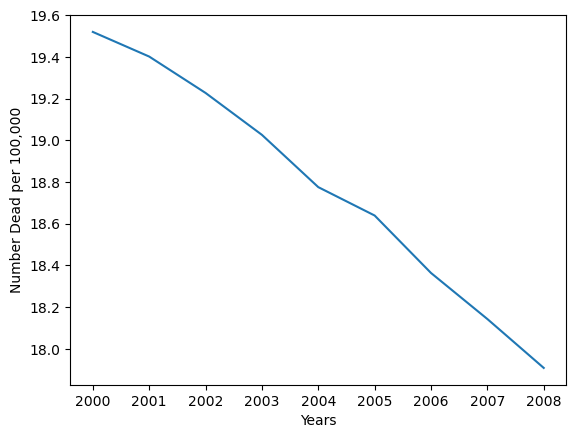

In [ ]:
ax = sns.lineplot(data=df_male_suicides, x=df_male_suicides["index"], y=df_male_suicides[2])
ax.set(xlabel="Years", ylabel="Number Dead per 100,000")

We created a seperate dataframe 'df_female_suicides', to get the column statistic for the suicide rates of Females.

In [ ]:
df_female_suicides = df_all_combined_nocountry_grouped[df_all_combined_nocountry_grouped["Statistic"] == "Female"]
df_female_suicides = df_female_suicides.drop(columns=["Statistic"]).T.reset_index()
df_female_suicides

Plotted below, is the visual data of the female suicide rates and the years we are looking at in our analysis.

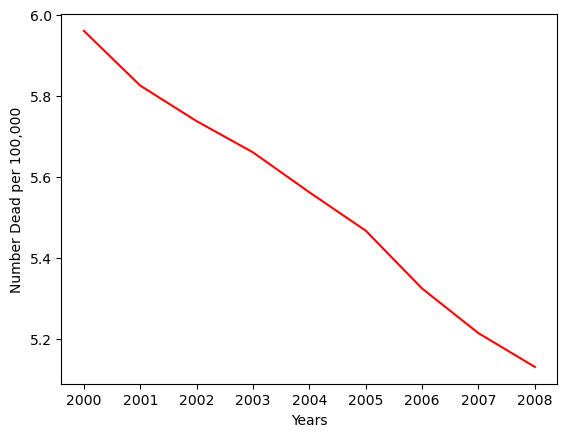

In [ ]:
ax = sns.lineplot(data=df_female_suicides, x=df_female_suicides["index"], y=df_female_suicides[1], color="r")
ax.set(xlabel="Years", ylabel="Number Dead per 100,000")
plt.show()

## Male v. Female Suicides

In the plot below, we compared the suicide rates between both males and females.

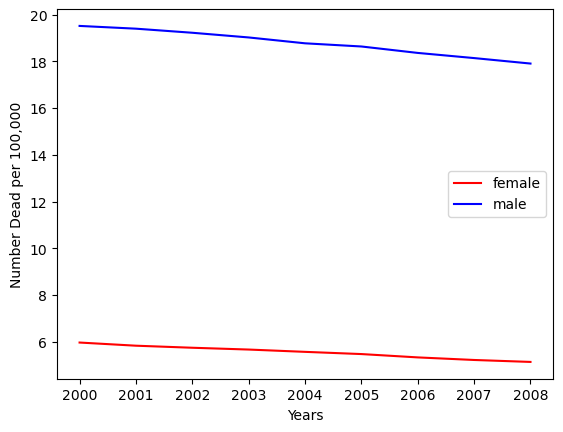

In [ ]:
fig,ax = plt.subplots()
plt.plot(df_female_suicides["index"], df_female_suicides[1], label = "female",color = 'red')
plt.plot(df_male_suicides["index"], df_male_suicides[2], label = "male",color = 'blue')
ax.set(xlabel="Years", ylabel="Number Dead per 100,000")
plt.legend()
plt.show()

We created a seperate dataframe 'df_emissions', to get the column statistic for CO2 emissions, total (KtCO2).

In [ ]:
df_emissions = df_all_combined_nocountry_grouped[df_all_combined_nocountry_grouped["Statistic"] == "CO2 emissions, total (KtCO2)"]
df_emissions = df_emissions.drop(columns=["Statistic"]).T.reset_index()
df_emissions

## Normalize Dataset Values

For the datasets (df_emissions, df_male_suicides, df_female_suicides), we normalized the data so the range across all datasets will be from 0-100.

In [ ]:
df_emissions[0] = 100 * (df_emissions[0] - df_emissions[0].min()) / (df_emissions[0].max() - df_emissions[0].min())
df_emissions

In [ ]:
df_male_suicides[2] = 100 * (df_male_suicides[2] - df_male_suicides[2].min()) / (df_male_suicides[2].max() - df_male_suicides[2].min())
df_female_suicides[1] = 100 * (df_female_suicides[1] - df_female_suicides[1].min()) / (df_female_suicides[1].max() - df_female_suicides[1].min())
df_male_suicides.head(5)

## Comparison

Plotted below is the rate of suicide rates from both males and females, as well as the rate of CO2 emission across the years we are looking at in our analysis.

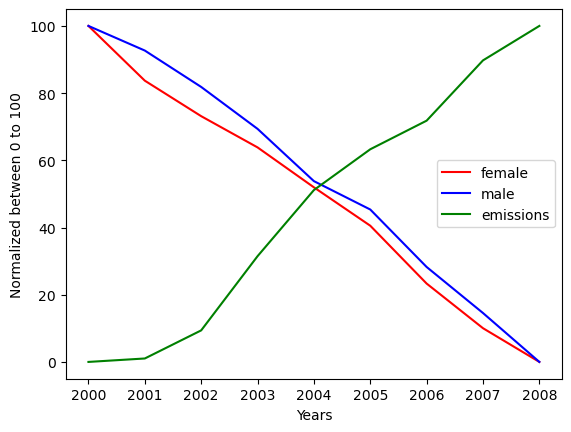

In [ ]:
fig,ax = plt.subplots()
plt.plot(df_female_suicides["index"], df_female_suicides[1], label = "female",color = 'red')
plt.plot(df_male_suicides["index"], df_male_suicides[2], label = "male", color = 'blue')
plt.plot(df_emissions["index"], df_emissions[0], label = "emissions",color = 'green')
ax.set(xlabel="Years", ylabel="Normalized between 0 to 100")
plt.legend()

We created a dataframe 'result', that merges both df_emissions and df_male_suicides to be put into a linear regression model comparing the two.

In [ ]:
result = pd.merge(df_emissions,df_male_suicides)
result.rename({0:"emissions",2:"mSuicides"},axis =1, inplace=True)
result


The linear regression model below compares CO2 emissions and male suicide rates.

In [ ]:
outcome_1, predictors_1 = patsy.dmatrices('emissions ~ mSuicides', result)

mod_1 = sm.OLS(outcome_1, predictors_1)

res_1 = mod_1.fit()

print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:              emissions   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     439.0
Date:                Sun, 20 Nov 2022   Prob (F-statistic):           1.42e-07
Time:                        20:50:53   Log-Likelihood:                -26.267
No. Observations:                   9   AIC:                             56.53
Df Residuals:                       7   BIC:                             56.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    104.3764      3.243     32.186      0.0

We created a dataframe 'result1', that merges both df_emissions and df_female_suicides to be put into a linear regression model comparing the two.

In [ ]:
result1 = pd.merge(df_emissions,df_female_suicides)
result1.rename({0:"emissions",1:"fSuicides"},axis =1, inplace=True)
result1

The linear regression model below compares CO2 emissions and female suicide rates.

In [ ]:
outcome_2, predictors_2 = patsy.dmatrices('emissions ~ fSuicides', result1)

mod_2 = sm.OLS(outcome_2, predictors_2)

res_2 = mod_2.fit()

print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:              emissions   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     203.6
Date:                Sun, 20 Nov 2022   Prob (F-statistic):           1.97e-06
Time:                        20:50:54   Log-Likelihood:                -29.644
No. Observations:                   9   AIC:                             63.29
Df Residuals:                       7   BIC:                             63.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    100.8052      4.538     22.213      0.0

## Conclusions

# Natural Disasters v. Suicide Rates

We created a seperate dataframe 'df_natural_disasters', to get the column statistic for number of people affected by natural disasters.

In [ ]:
df_natural_disasters = df_all_combined_nocountry_grouped[df_all_combined_nocountry_grouped["Statistic"] == "Number of People Affected"]
df_natural_disasters = df_natural_disasters.drop(columns=["Statistic"]).T.reset_index()
df_natural_disasters

Plotted below is the rate of the number of people affected by natural disasters across the years we are analyzing for.

[Text(0.5, 0, 'Years'),
 Text(0, 0.5, 'Number of People Affected by Natural Disasters')]

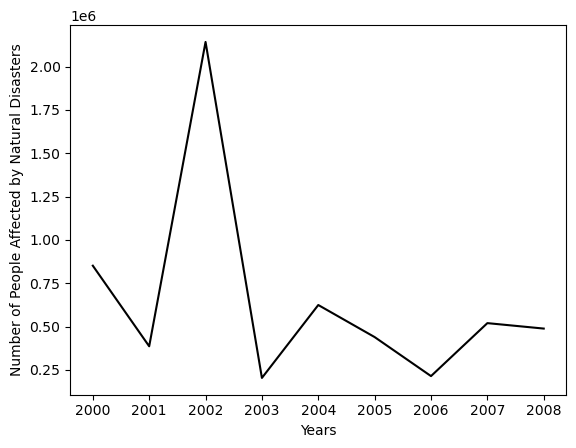

In [ ]:
ax = sns.lineplot(data=df_natural_disasters, x=df_natural_disasters["index"], y=df_natural_disasters[4], color="black")
ax.set(xlabel="Years", ylabel="Number of People Affected by Natural Disasters")

We created a seperate dataframe 'df_homeless', to get the column statistic for number of people left homeless by natural disasters.

In [ ]:
df_homeless = df_all_combined_nocountry_grouped[df_all_combined_nocountry_grouped["Statistic"] == "Number of Homeless"]
df_homeless = df_homeless.drop(columns=["Statistic"]).T.reset_index()
df_homeless

Plotted below is the rate of the number of people left homeless by natural disasters across the years we are analyzing for.

[Text(0.5, 0, 'Years'),
 Text(0, 0.5, 'Number of People Left Homeless by Natural Disasters')]

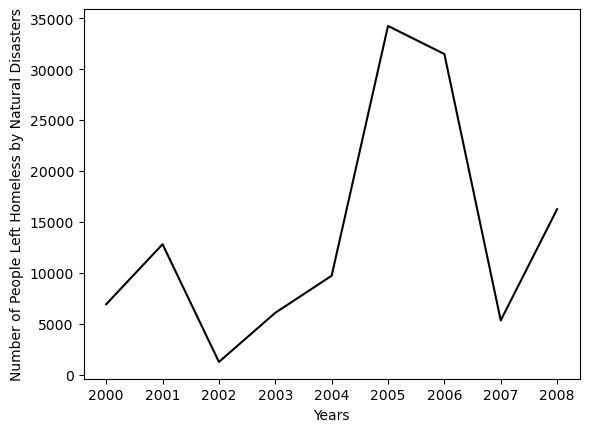

In [ ]:
ax = sns.lineplot(data=df_homeless, x=df_homeless["index"], y=df_homeless[3], color="black")
ax.set(xlabel="Years", ylabel="Number of People Left Homeless by Natural Disasters")

We created a seperate dataframe 'df_male_suicides', to get the column statistic for number of male suicides.

In [ ]:
df_male_suicides = df_all_combined_nocountry_grouped[df_all_combined_nocountry_grouped["Statistic"] == "Male"]
df_male_suicides = df_male_suicides.drop(columns=["Statistic"]).T.reset_index()
df_male_suicides

Plotted below is the rate of male suicide rates across the years we are analyzing for.

[Text(0.5, 0, 'Years'), Text(0, 0.5, 'Number Dead per 100,000')]

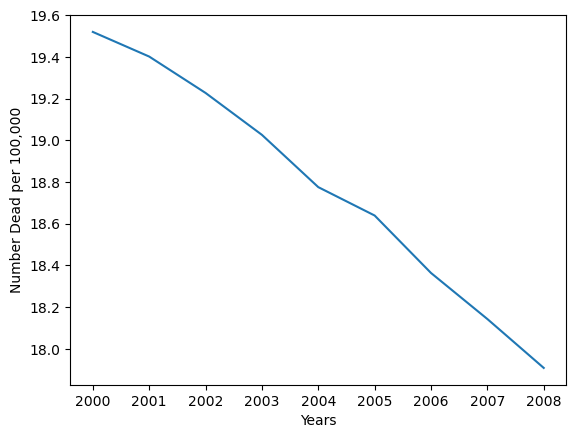

In [ ]:
ax = sns.lineplot(data=df_male_suicides, x=df_male_suicides["index"], y=df_male_suicides[2])
ax.set(xlabel="Years", ylabel="Number Dead per 100,000")

We created a seperate dataframe 'df_female_suicides', to get the column statistic for number of female suicides.

In [ ]:
df_female_suicides = df_all_combined_nocountry_grouped[df_all_combined_nocountry_grouped["Statistic"] == "Female"]
df_female_suicides = df_female_suicides.drop(columns=["Statistic"]).T.reset_index()
df_female_suicides

Plotted below is the rate of female suicide rates across the years we are analyzing for.

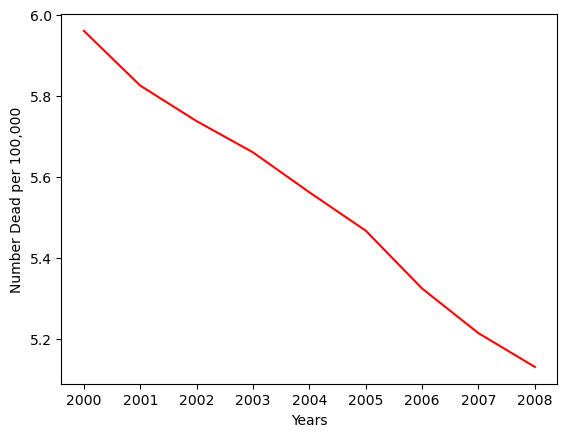

In [ ]:
ax = sns.lineplot(data=df_female_suicides, x=df_female_suicides["index"], y=df_female_suicides[1], color="r")
ax.set(xlabel="Years", ylabel="Number Dead per 100,000")
plt.show()

We created a graph showing the relations between the df_female_suicides, df_male_suicides, df_homeless and df_natural_disasters before we normalized the datasets.

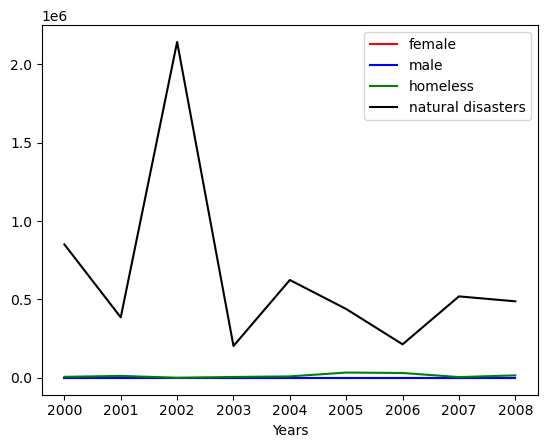

In [ ]:
fig,ax = plt.subplots()
plt.plot(df_female_suicides["index"], df_female_suicides[1], label = "female",color = 'red')
plt.plot(df_male_suicides["index"], df_male_suicides[2], label = "male",color = 'blue')
plt.plot(df_homeless["index"], df_homeless[3], label = "homeless",color = 'green')
plt.plot(df_natural_disasters["index"], df_natural_disasters[4], label = "natural disasters",color = 'black')
ax.set(xlabel="Years", ylabel="Non Normalized")
plt.legend()

# Normalize Datasets

For the datasets (df_homeless, df_natural_disasters, df_male_suicides, df_female_suicides), we normalized the data so the range across all datasets will be from 0-100.

In [ ]:
df_homeless[3] = 100 * (df_homeless[3] - df_homeless[3].min()) / (df_homeless[3].max() - df_homeless[3].min())
df_natural_disasters[4] = 100 * (df_natural_disasters[4] - df_natural_disasters[4].min()) / (df_natural_disasters[4].max() - df_natural_disasters[4].min())
df_homeless

In [ ]:
df_male_suicides[2] = 100 * (df_male_suicides[2] - df_male_suicides[2].min()) / (df_male_suicides[2].max() - df_male_suicides[2].min())
df_female_suicides[1] = 100 * (df_female_suicides[1] - df_female_suicides[1].min()) / (df_female_suicides[1].max() - df_female_suicides[1].min())
df_male_suicides.head(5)

## Comparison

We created a graph showing the relations between the df_female_suicides, df_male_suicides, df_homeless and df_natural_disasters after we normalized the datasets to accurately see the correlation between the dataframes.

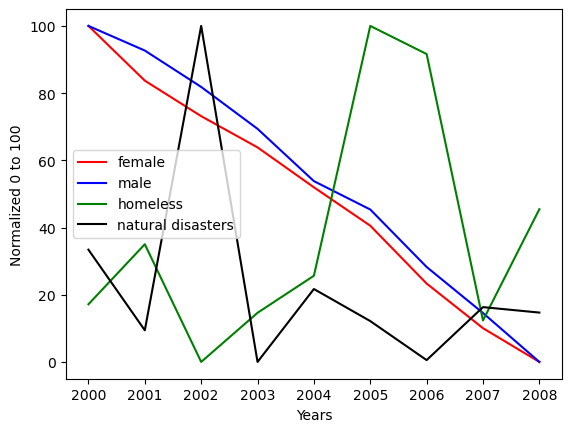

In [ ]:
fig,ax1 = plt.subplots()
plt.plot(df_female_suicides["index"], df_female_suicides[1], label = "female",color = 'red')
plt.plot(df_male_suicides["index"], df_male_suicides[2], label = "male",color = 'blue')
plt.plot(df_homeless["index"], df_homeless[3], label = "homeless",color = 'green')
plt.plot(df_natural_disasters["index"], df_natural_disasters[4], label = "natural disasters",color = 'black')
ax1.set(xlabel="Years", ylabel="Normalized 0 to 100")
plt.legend()

We created a dataframe 'result3', that merges both df_homeless and df_male_suicides to be put into a linear regression model comparing the two.

In [ ]:
result3 = pd.merge(df_homeless,df_male_suicides)
result3.rename({3:"homeless",2:"mSuicides"},axis =1, inplace=True)
result3

The linear regression model below compares number of people left homeless by natural disasters and male suicide rates.

In [ ]:
outcome_3, predictors_3 = patsy.dmatrices('homeless ~ mSuicides', result3)

mod_3 = sm.OLS(outcome_3, predictors_3)

res_3 = mod_3.fit()

print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:               homeless   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.199
Date:                Sun, 20 Nov 2022   Prob (F-statistic):              0.310
Time:                        20:50:59   Log-Likelihood:                -43.627
No. Observations:                   9   AIC:                             91.25
Df Residuals:                       7   BIC:                             91.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.8310     22.316      2.636      0.0

We created a dataframe 'result4', that merges both df_homeless and df_female_suicides to be put into a linear regression model comparing the two.

In [ ]:
result4 = pd.merge(df_homeless,df_female_suicides)
result4.rename({3:"homeless",1:"fSuicides"},axis =1, inplace=True)
result4

The linear regression model below compares number of people left homeless by natural disasters and female suicide rates.

In [ ]:
outcome_4, predictors_4 = patsy.dmatrices('homeless ~ fSuicides', result4)

mod_4 = sm.OLS(outcome_4, predictors_4)

res_4 = mod_4.fit()

print(res_4.summary())

                            OLS Regression Results                            
Dep. Variable:               homeless   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.238
Date:                Sun, 20 Nov 2022   Prob (F-statistic):              0.303
Time:                        20:51:00   Log-Likelihood:                -43.606
No. Observations:                   9   AIC:                             91.21
Df Residuals:                       7   BIC:                             91.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.9925     21.409      2.709      0.0

## Conclusion

# Natural Disaster v. Carbon Emissions

We created a seperate dataframe 'df_natural disasters', to get the column statistic for the number of people affected by natural disasters.

In [ ]:
df_natural_disasters = df_all_combined_nocountry_grouped[df_all_combined_nocountry_grouped["Statistic"] == "Number of People Affected"]
df_natural_disasters = df_natural_disasters.drop(columns=["Statistic"]).T.reset_index()
df_natural_disasters

[Text(0.5, 0, 'Years'),
 Text(0, 0.5, 'Number of People Affected by Natural Disasters')]

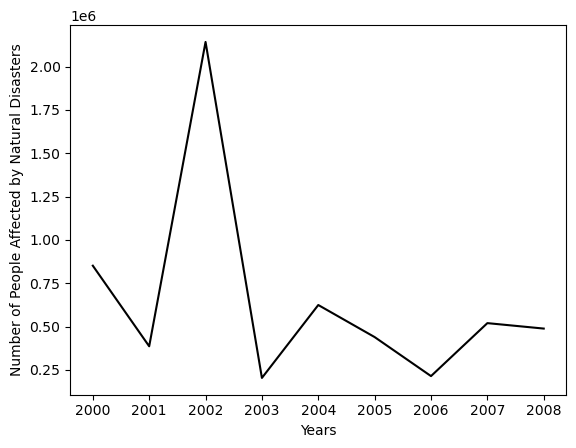

In [ ]:
ax = sns.lineplot(data=df_natural_disasters, x=df_natural_disasters["index"], y=df_natural_disasters[4], color="black")
ax.set(xlabel="Years", ylabel="Number of People Affected by Natural Disasters")

We created a seperate dataframe 'df_global_emissions', to get the column statistic for the rising global temperatures measured by total Co2 emissions.

In [ ]:
df_global_emissions = df_all_combined_nocountry_grouped[df_all_combined_nocountry_grouped["Statistic"] == "CO2 emissions, total (KtCO2)"]
df_global_emissions = df_global_emissions.drop(columns=["Statistic"]).T.reset_index()
df_global_emissions

Plotted below is the rate of CO2 emissions across the years we are analyzing for

[Text(0.5, 0, 'Years'), Text(0, 0.5, 'CO2 Levels')]

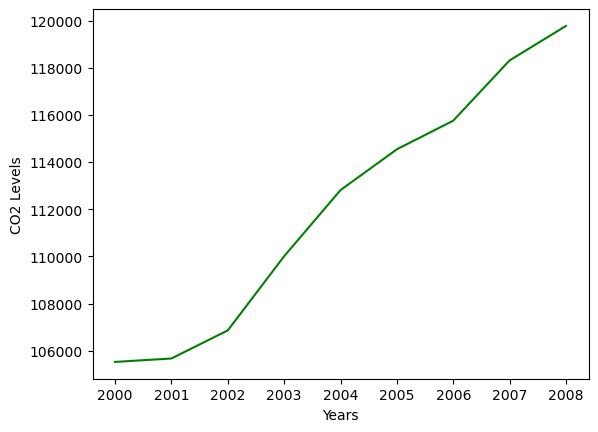

In [ ]:
ax = sns.lineplot(data=df_global_emissions, x=df_global_emissions["index"], y=df_global_emissions[0], color="green")
ax.set(xlabel="Years", ylabel="CO2 Levels")

## Normalize Dataset Values

For the datasets (df_natural_disasters, df_global_emissions), we normalized the data so the range across all datasets will be from 0-100.

In [ ]:
df_natural_disasters[4] = 100 * (df_natural_disasters[4] - df_natural_disasters[4].min()) / (df_natural_disasters[4].max() - df_natural_disasters[4].min())
df_natural_disasters

In [ ]:
df_global_emissions[0] = 100 * (df_global_emissions[0] - df_global_emissions[0].min()) / (df_global_emissions[0].max() - df_global_emissions[0].min())
df_global_emissions

## Comparison

Plotted below is the rate of natural disasters, as well as the rate of CO2 emission across the years we are looking at in our analysis.

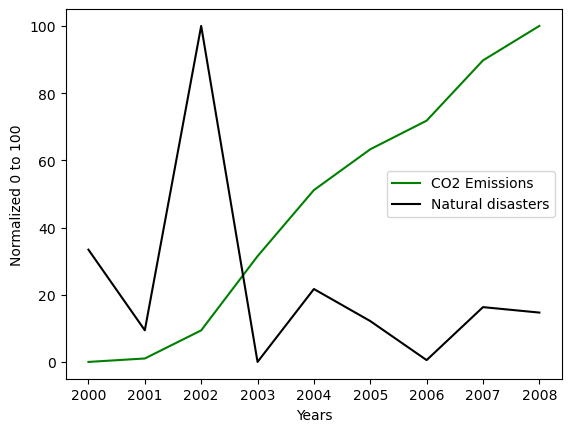

In [ ]:
fig,ax2 = plt.subplots()
plt.plot(df_global_emissions["index"], df_global_emissions[0], label = "CO2 Emissions",color = 'green')
plt.plot(df_natural_disasters["index"], df_natural_disasters[4], label = "Natural disasters",color = 'black')
ax2.set(xlabel="Years", ylabel="Normalized 0 to 100")
plt.legend()

We created a dataframe 'result5', that merges both df_homeless and df_global_emissions to be put into a linear regression model comparing the two.

In [ ]:
result5 = pd.merge(df_homeless,df_global_emissions)
result5.rename({3:"homeless",0:"globalemissions"},axis =1, inplace=True)
result5

The linear regression model below compares number of people left homeless by natural disasters and rising global temperatures.

In [ ]:
outcome_5, predictors_5 = patsy.dmatrices('homeless ~ globalemissions', result5)

mod_5 = sm.OLS(outcome_5, predictors_5)

res_5 = mod_5.fit()

print(res_5.summary())

                            OLS Regression Results                            
Dep. Variable:               homeless   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     1.488
Date:                Sun, 20 Nov 2022   Prob (F-statistic):              0.262
Time:                        20:51:03   Log-Likelihood:                -43.471
No. Observations:                   9   AIC:                             90.94
Df Residuals:                       7   BIC:                             91.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          19.8499     18.768     

## Conclusion